# Visual Covariance Test

$$
% latex macros.  this does not work when converting to latex.
\newcommand{\bm}[1]{\boldsymbol{#1}}
\DeclareMathOperator{\cov}{cov}
\DeclareMathOperator{\diag}{diag}
\newcommand{\ud}{\mathrm{d}}
\newcommand{\XX}{{\bm X}}
\newcommand{\VV}{{\bm V}}
\newcommand{\N}{\mathcal{N}}
\newcommand{\mmu}{{\bm \mu}}
\newcommand{\SSi}{{\bm \Sigma}}
\newcommand{\ssi}{{\bm \sigma}}
$$

Pick a covariance type. Then for $x_t$ and $v_t = \ud x_t/\ud t$, visually check that
$$
\begin{aligned}
\cov(x_t, v_s) & = \int_0^t \cov(v_u, v_s) \, \ud u \\
\cov(x_t, x_s) & = \int_0^t\int_0^s \cov(v_u, v_w) \, \ud u\, \ud w
\end{aligned}
$$
by comparing analytic formula to numerical integration with `scipy.integrate.quad` and `scipy.integrate.dblquad`.

In [1]:
import os
os.chdir('C:\\Users\\mohan\\Documents\\probDE')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform as runif
from scipy import integrate
import BayesODE as bo
from Tests.ode_bayes_star import ode_bayes_star

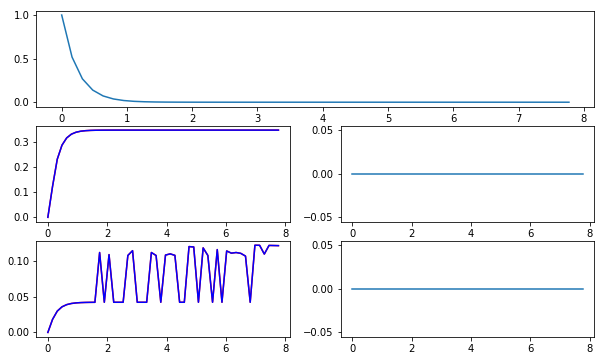

In [3]:
npts = 50
# pick covariance type
type = "ex"
if type == "se":
    cov_vv = bo.cov_vv_se
    cov_xv = bo.cov_xv_se
    cov_xx = bo.cov_xx_se
elif type == "ex":
    cov_vv = bo.cov_vv_ex
    cov_xv = bo.cov_xv_ex
    cov_xx = bo.cov_xx_ex
elif type == "re":
    cov_vv = bo.cov_vv_re
    cov_xv = bo.cov_xv_re
    cov_xx = bo.cov_xx_re
else:
    raise ValueError("Invalid covariance type.")
# plot cov_vv
tmax = runif(low = 0, high = 10, size = 1)
gamma = runif(0, tmax/10, 1)
tseq = np.linspace(start = 0, stop = tmax, num = npts)
av = np.zeros((npts, 1))
for ii in range(0,npts):
    av[ii] = cov_vv(0, tseq[ii], gamma)
plt.rcParams['figure.figsize'] = [10, 6]
plt.subplot(3,2,(1,2))
plt.plot(tseq,av)
# integrate once and compare to analytic solution
t = runif(0, tmax, 1) # first time point
s = runif(0, tmax, 1) # second time point
tseq = np.linspace(start = 0, stop = tmax, num = npts)
xv_an = np.zeros((npts,1)) # analytic solution
xv_nu = xv_an # numeric solution
for ii in range(0,npts):
    xv_an[ii] = cov_xv(tseq[ii], s, gamma)
    xv_nu[ii],err = integrate.quad(cov_vv, 0, tseq[ii], args=(s,gamma))
plt.subplot(3,2,3)
plt.plot(tseq,xv_an,'r',tseq,xv_nu,'b')
plt.subplot(3,2,4)
plt.plot(tseq,abs(xv_an-xv_nu))
# integrate twice and compare to analytic solution
xx_an = np.zeros((npts,1)) # analytic solution
xx_nu = xx_an # numeric solution
for ii in range(0,npts):
    xx_an[ii] = cov_xx(tseq[ii], s, gamma)
    xx_nu[ii],err = integrate.dblquad(cov_vv, 0, tseq[ii], 0, s, args = (gamma))
plt.subplot(3,2,5)
plt.plot(tseq,xx_an,'r',tseq,xx_nu,'b')
plt.subplot(3,2,6)
plt.plot(tseq,abs(xx_an-xx_nu))

# Updating Algorithm Test

Let $T = (t_1, \ldots, t_N)$ denote the evaluation time points, and $\XX$ and $\VV$ denote vectors of length $N$ corresponding to $x(T)$ and $v(T)$.  The solution prior is then expressed as
$$
\begin{bmatrix} \XX \\ \VV \end{bmatrix} \sim \N\left(\begin{bmatrix} \mmu_X \\ \mmu_V \end{bmatrix}, \begin{bmatrix} \SSi_{XX} & \SSi_{XV} \\ \SSi_{VX} & \SSi_{VV} \end{bmatrix} \right).
$$
Now suppose that the $N$ model interrogations $\VV_\star$ and their predictive variances $\ssi_\star^2$ are given in advance.  Then joint distribution of $(\XX, \VV, \VV_\star)$ is
$$
\begin{bmatrix} \XX \\ \VV \\ \VV_\star \end{bmatrix} \sim \N\left(\begin{bmatrix} \mmu_X \\ \mmu_V \\ \mmu_V \end{bmatrix}, \begin{bmatrix} \SSi_{XX} & \SSi_{XV} & \SSi_{XV} \\ \SSi_{VX} & \SSi_{VV} & \SSi_{VV} \\ \SSi_{VX} & \SSi_{VV} & \SSi_{VV} + \diag(\ssi_\star^2) \end{bmatrix} \right),
$$
from which we can deduce calculate the mean and variance of the final update (normal) distribution, $p(\XX \mid \VV_\star)$.  This suggests the following unit test for the ODE solver:

1. Modify `ode_bayes` such that it accepts an optional input of $\VV_\star$ and $\ssi_\star^2$ (please use argument names consistent with the rest of the function).
2. Write a function to compute the mean and variance of $p(\XX \mid \VV_\star)$ based on $(\mmu_X, \mmu_V, \SSi_{XX}, \SSi_{XV}, \SSi_{VV}, \VV_\star)$.
3. Run `ode_bayes` with predetermined $(\VV_\star, \ssi_\star^2)$, and check that the mean and variance output is identical to that of step 2.

In [4]:
#Toy example
def f(x,t):
    return  3*(t+1/4) - x/(t+1/4)

a = 0
b = 4.75
x0 = 10
N = 100
tseq = np.linspace(a, b, N)
w = gamma = (b-a)/(N-1)
alpha = N/10

mu_v = np.zeros((N)) # prior mean of v(tseq)
mu_x = x0 + mu_v # prior mean of x(tseq)
Sigma_vv, Sigma_xx, Sigma_xv = bo.cov_prior(tseq, 'exp', gamma, alpha)

In [5]:
x = integrate.odeint(f,x0,tseq)
x = np.ndarray.flatten(x)
sigma_star_avg = (max(x) - min(x))*0.05

upper = 3*sigma_star_avg/2
lower = sigma_star_avg/2

sigma_star = runif(lower, upper)
vstar = x+sigma_star*np.random.normal(0,1)

In [11]:
mu_star, Sigma_star = ode_bayes_star(mu_x, mu_v, Sigma_vv, Sigma_xx, Sigma_xv, vstar)

In [12]:
a, mu_x, Sigma_xx = bo.ode_bayes(f, tseq, x0, Sigma_vv, Sigma_xx, Sigma_xv, vstar)

C:\Users\mohan\Documents\probDE\BayesODE\ode_bayes.py:50: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu_x, Sigma_xx), mu_x, Sigma_xx


In [13]:
np.allclose(mu_star, mu_x), np.allclose(Sigma_star, Sigma_xx)

(True, True)

In [15]:
from pykalman import KalmanFilter

In [45]:
def bayes_ode_kalman(fun, x0, tseq, gamma, alpha):
    N = len(tseq)
    mu = np.array([[x0, fun(x0, tseq[0])]]*N)
    Sigma_vv, Sigma_xx, Sigma_xv = bo.cov_prior(tseq, 'exp', gamma, alpha)
    Sigma_vv = bo.cov_vv_ex(tseq[0], tseq[0], gamma)/alpha
    Sigma_xx = bo.cov_xx_ex(tseq[0], tseq[0], gamma)/alpha
    Sigma_xv = bo.cov_xv_ex(tseq[0], tseq[0], gamma)/alpha
    Sigma = np.array([[[Sigma_xx, Sigma_xv], [Sigma_xv, Sigma_vv]]]*N)
    yt = np.array([mu[0]]*N)
    kf = KalmanFilter(initial_state_mean=mu[0], initial_state_covariance=Sigma[0], n_dim_obs=2) #Initialization of Kalman Filter
    for n in range(N-1):
        mu[n+1], Sigma[n+1] = kf.filter_update(mu[n], Sigma[n], yt[n])
        #Model Interrogation Step
        xt = np.random.normal(mu[n+1,0], Sigma[n+1,0,0]) # interrogation of x_t
        vt = fun(xt, tseq[n+1]) # interrogation of v_t
        yt[n+1] = [xt, vt]
        
    
    kf2 = KalmanFilter(initial_state_mean=mu[0], initial_state_covariance=Sigma[0], n_dim_obs=2)
    yt_mean = kf2.smooth(yt)[0]
    
    return mu, yt_mean

In [46]:
m, yt_mean = bayes_ode_kalman(f, 10, tseq, gamma, alpha)